# Generative Learning Using a Quantum Computer

In this tutorial, we implement Data-driven quantum circuit learning (DDQCL), based on the 2019 paper [Training of quantum circuits on a hybrid quantum computer](https://advances.sciencemag.org/content/5/10/eaaw9918) by Zhu et. al, using the Amazon Braket SDK.

### DQCCL
DDQCL is a hybrid quantum-classical technique for generative modeling of classical data, using a parametrized quantum circuit as the model being trained. Training occurs by sampling the output of a parametrized circuit run on a quantum computer and updating the circuit parameters using classical optimization techniques. Convergence produces a circuit that captures the correlations in the training data, thus serving as a generative model for the data itself.

### The Bars-And-Stripes (BAS) Dataset
The data we will be training against is a canonical ensemble that works like so: for an $n \times m$ matrix, each cell can either be on (filled-in) or off (blank); it is a valid BAS example if it contains only completely filled rows (bars) or columns (stripes). 

For a 2x2 matrix, like we will be using in this example, this allows for six valid patterns of 16 total permutations:
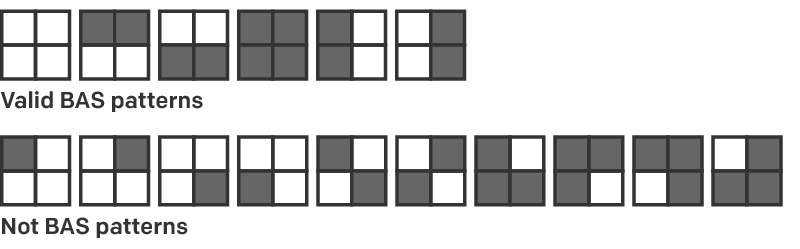

We encode this as a binary string by reading left-to-right, top-to-bottom, with a filled-in cell representing a 1 and a blank cell a 0; the above valid examples translate (in order) to 0000, 1100, 0011, 0000, 1010, and 0101.

## Implementation
We will be implementing this technique using the Braket local simulator and noisyopt, a python library for optimizing noisy functions. To do that, we'll need to define
1. A generator for our BAS training data
2. A generator for our parametrized circuit
3. A cost function for our optimizer
4. A few additional helper methods for accessing and storing these data using the Braket SDK
5. The hybrid learning algorithm itself, using all of the above

## Imports and Setup

First, we'll do some setup that will allow us to build, optimize, visualize, store, and retrieve the circuits we'll be running via the Braket SDK.

First, get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package included with this notebook using `pip`:

```bash
pip install qiskit_ionq_provider-0.0.1.dev0+45bd6b1-py3-none-any.whl
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [1]:
# general imports
import math
import time
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime

# Noisy optimization package — you could also use scipy's optimization functions, 
# but this is a little better suited to the noisy output of NISQ devices.
%pip install noisyopt
import noisyopt

# magic invocation for producing visualizations in notebook
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pkgs.dev.azure.com/ms-quantum-public/9af4e09e-a436-4aca-9559-2094cfe8d80c/_packaging/alpha/pypi/simple/
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Qiskit imports
from qiskit import Aer

from qiskit_ionq_provider import IonQProvider 

#Call provider and set token value
provider = IonQProvider(token='7qJgrdKSohxnhu3tm1dHKt:62bIzCX9rLTJqKfPZB74qv')

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:


In [3]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x7f0b28167550>()>,
 <IonQQPUBackend('ionq_qpu') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x7f0b28167550>()>]

In [4]:
# fix random seed for reproducibility — this allows us to re-run the process and get the same results
seed = 42
np.random.seed(seed)
random.seed(a=seed)

## BAS Generator

Here we generate our bars and stripes — as this is just a proof-of-principle, we are limiting the possible outputs to the four single-bar or single-stripe outputs to keep convergence time (and therefore training cost) low.

In [5]:
#Generate BAS, only one bar or stripe allowed
def generate_target_distribution(rows, columns):        
    #Stripes
    states=[]
    for i in range(rows):
        s=['0']*rows*columns
        for j in range(columns):
            s[j+columns*i]='1'
        states.append(''.join(s))
                
        
    #Bars
    for j in range(columns):
        s=['0']*rows*columns
        for i in range(rows):
            s[j+columns*i]='1'
        states.append(''.join(s))
        
    return states

## Circuit Generator

Here we define several driver functions which consist of parametrized one qubit gates that help to explore the Hilbert space, and several entangler functions that generate entanglement in the system. 

The complete circuit ansatz consists of repeating layers of the drivers and entanglers. The parameters ($\gamma$ and $\beta$) of the ansatz are iteratively optimized (learned) by our hybrid quantum-clasical routine.

In [6]:
#Parameters for driver
def generate_beta(ansatz_type,random_init):
    if ansatz_type[0]==0: #No driver
        beta=[]
    elif ansatz_type[0]==1: #Rz(t1)Rx(t2)Rz(t3), angles different for each qubit
        beta=(
            [random.uniform(0.0,2.*math.pi) for i in range(3*n*(layers-1))] 
            if random_init 
            else [0]*3*n*(layers-1)
        )
    elif ansatz_type[0]==2: #Rz(t1)Rx(t2)Rz(t3), angles same for all qubits
        beta=(
            [random.uniform(0.0,2.*math.pi) for i in range(3*(layers-1))]
            if random_init
            else [0]*3*(layers-1)
        )
    elif ansatz_type[0]==3: #Rz(t1), angles different for each qubit
        beta=(
            [random.uniform(0.0,2.*math.pi) for i in range(n*(layers-1))]
            if random_init
            else [0]*n*(layers-1)
        )
    else:
        raise Exception("Undefined driver type")
            
    return beta

#Parameters for entangler
def generate_gamma(ansatz_type,random_init, n, conn):
    length_gamma=int(n*conn-conn*(conn+1)/2.)
    if ansatz_type[1]==0: #No entangler
        gamma=[]
    elif ansatz_type[1]==1: #XX(t1), angles different for each qubit
        gamma=(
            [random.uniform(0.0,2.*math.pi) for i in range(length_gamma*layers)]
            if random_init
            else [0]*length_gamma*layers
        )
    elif ansatz_type[1]==2: #XX(t1), angles same for all qubits
        gamma=(
            [random.uniform(0.0,2.*math.pi) for i in range(layers)]
            if random_init
            else gamma[0]*layers
        )
    else:
        raise Exception("Undefined entangler type")
            
    return gamma


In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate

def driver(circ,qr,beta,n,ansatz_type):
    #qr=QuantumRegister(n)
    #circ = QuantumCircuit(qr)
    
    if ansatz_type==0:
        pass
    elif ansatz_type==1:
        for i_q in range(n):
            circ.rz(beta[3*i_q], qr[i_q])
            circ.rx(beta[3*i_q+1], qr[i_q])
            circ.rz(beta[3*i_q+2], qr[i_q])
    elif ansatz_type==2:
        for i_q in range(n):
            circ.rz(beta[0], qr[i_q])
            circ.rx(beta[1], qr[i_q])
            circ.rz(beta[2], qr[i_q])
    elif ansatz_type==3:
        for i_q in range(n):
            circ.rz(beta[i_q], qr[i_q])        
    
    return

def entangler(circ,qr,gamma,n,conn,ansatz_type):
    #qr=QuantumRegister(n)
    #cr=ClassicalRegister(n)
    #circ = QuantumCircuit(qr)

    if ansatz_type==0:
        pass
    elif ansatz_type==1:
        i_gamma=0
        for i_conn in range(1,conn+1):
            for i_q in range(0,n-i_conn):  
                circ.cx(qr[i_q],qr[i_q+i_conn])
                circ.rx(gamma[i_gamma],qr[i_q])
                circ.cx(qr[i_q],qr[i_q+i_conn])
                #circ.rxx(gamma[i_gamma], qr[i_q], qr[i_q+i_conn])
                i_gamma+=1            
                
    elif ansatz_type==2:
        for i_conn in range(1,conn+1):
            for i_q in range(0,n-i_conn): 
                circ.cx(qr[i_q],qr[i_q+i_conn])
                circ.rx(gamma[0],qr[i_q])
                circ.cx(qr[i_q],qr[i_q+i_conn])                                                       #circ.rxx(gamma[0], qr[i_q], qr[i_q+i_conn])
    
    #circ.measure(qr,cr)
    return
    
#Define circuit ansatz
def circuit_ansatz(n,params,conn=1, layers=1, ansatz_type=[1,1]):
    qr=QuantumRegister(n)
    cr=ClassicalRegister(n)
    circ = QuantumCircuit(qr,cr)
    if ansatz_type[0]==0:
        length_beta=0
    elif ansatz_type[0]==1:
        length_beta=3*n
    elif ansatz_type[0]==2:
        length_beta=3
    elif ansatz_type[0]==3:
        length_beta=n
        
    if ansatz_type[1]==0:
        length_gamma=0
    elif ansatz_type[1]==1:
        length_gamma=int(n*conn-conn*(conn+1)/2.)            
    elif ansatz_type[1]==2:
        length_gamma=1

 
    for i_layer in range(layers-1):       
        
        beta=params[(length_beta+length_gamma)*i_layer:(length_beta+length_gamma)*i_layer+length_beta]
        gamma=params[(length_beta+length_gamma)*i_layer+length_beta:(length_beta+length_gamma)*(i_layer+1)]
        
        entangler(circ,qr,gamma,n,conn,ansatz_type[1])
        driver(circ,qr,beta,n,ansatz_type[0])
    
    gamma=params[(length_beta+length_gamma)*(layers-1):]
    entangler(circ,qr,gamma,n,conn,ansatz_type[1])
    circ.measure(qr, cr)
    
    return circ

## Cost function

Here, we define our cost function to feed to the optimization routine, which takes the form of a regularized Kullback-Leibler Divergence ([Quick Overview](https://medium.com/@cdefaux/kullback-leibler-divergence-for-dummies-c3613bc80ad3), [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)).

In [8]:
def cost(counts, shots, target_states,tol=0.0001):
    cost=0
    for state in target_states:
        if state in counts:
            cost-=1./len(target_states)*np.log2(max(tol,counts[state]/shots))
        else:
            cost-=1./len(target_states)*np.log2(tol)
    return cost

## Helper Methods

Finally, we define two helper methods: `run_iteration`, to run and return each iteration of our circuit (with some helpful tools for managing timeouts and waiting for results) and `run_circuit_and_calc_cost`, which  uses `run_iteration` to both run an interation of the circuit and calculate a new cost function, effectively taking a training step.

In [9]:
from qiskit.providers.jobstatus import JobStatus

def run_iteration(circ, num_qubits, shots=100): 

    # submit task: define task (asynchronous)
    task_status=''
    while task_status != JobStatus.DONE:
        
            task = backend.run(circ, shots)  
            #print("Job submitted")      
    
            # Get ID of submitted task
            task_id = task.job_id()
            #print('Task ID :', task_id)
            while (task_status == JobStatus.INITIALIZING) or (task_status == JobStatus.QUEUED)   or (task_status == JobStatus.VALIDATING) or (task_status == JobStatus.RUNNING) or (task_status==''):  
                time.sleep(1)
                try:
                    task_status=task.status()
                except:
                    print("Error querying status. Trying again.")
                    pass                    

        
        #print('Task status is', task_status)

    # get result
    counts = task.result().get_counts()

    return counts


#Run an iteration of the circuit and calculate its cost
def run_circuit_and_calc_cost(params, *args):
    n, conn, layers, ansatz_type, target_states, shots = args
    circ=circuit_ansatz(n, params, conn, layers,ansatz_type)
    counts=run_iteration(circ, n, shots=100)
    iter_cost=cost(counts, shots, target_states)
    cost_history.append(iter_cost)
    print("Current cost:", iter_cost)
    return iter_cost

# Running The Learning Algorithm

Now we're ready to run the learning algorithm and train our circuit.

### Choose Target Device

We need to do this first because we check against its capabilities when building the training data and circuit. We do not recommend running this this algorithm against a real hardware device until you have run it on a simulator to understand estimated price and if it will converge with the parameters you've selected.

So first, let's test it on the simulator

In [10]:
backend = provider.get_backend("ionq_simulator")

### Set Up Training Data

First, we'll set up our training data for the problem using the method we defined earlier.

In [11]:
#Set problem parameters
r=2 #Number of rows — make sure r*c is less than qubit count
c=2 #Number of columns — make sure r*c is less than qubit count
n=r*c #Qubits needed
conn=2 #Connectivity of the entangler.

#Check on qubit count
if n>backend.configuration().n_qubits:
    raise Exception("Too many qubits")

#Check on conn
if conn>(n-1):
    raise Exception("Connectivity is too large")
    
target_states=generate_target_distribution(r,c)

# Check expected output
print('Bitstrings that should be generated by trained circuit are', target_states, 'corresponding to the following BAS patterns:\n')
for state in target_states:
    for i in range(r):
        print(state[c*i:][:c].replace('0','□ ').replace('1','■ '))
    print('')

Bitstrings that should be generated by trained circuit are ['1100', '0011', '1010', '0101'] corresponding to the following BAS patterns:

■ ■ 
□ □ 

□ □ 
■ ■ 

■ □ 
■ □ 

□ ■ 
□ ■ 



### Set Up Training Parameters
Now, we'll set up our parameters for the training routine itself — these are all tunable; feel free to play with them to see how they impact the routine (especially when running on a local simulator!). Again, because this is just a proof-of-principle demo, we've selected some defaults that keep convergence time and training cost low.

In [12]:
# Choose entangler and driver type
layers=1 # Number of layers in each circuit
shots=100 # Number of shots per iteration
ansatz_type=[1,1]
random_init=False # Set to true for random initialization; will be slower to converge

# Set up args
beta=generate_beta(ansatz_type, random_init)
gamma=generate_gamma(ansatz_type, random_init, n, conn)
params=beta+gamma

base_bounds=(0,2.*math.pi)
bnds=((base_bounds , ) * len(params)) 

#Set up list to track cost history
cost_history=[]

max_iter=100 # max number of optimizer iterations

args=(n, conn, layers, ansatz_type, target_states, shots)
opts = {'disp': True, 'maxiter': max_iter, 'maxfev': max_iter, 'return_all': True}

#Visualize the circuit
circ=circuit_ansatz(n, params, conn,layers,ansatz_type)
circ.draw()

┌───────┐                                                ┌───────┐»
q0_0: ──■──┤ RX(0) ├──■──────────────────────────────────────────■──┤ RX(0) ├»
      ┌─┴─┐└───────┘┌─┴─┐     ┌───────┐                          │  └───────┘»
q0_1: ┤ X ├─────────┤ X ├──■──┤ RX(0) ├──■───────────────────────┼──────■────»
      └───┘         └───┘┌─┴─┐└───────┘┌─┴─┐     ┌───────┐     ┌─┴─┐    │    »
q0_2: ───────────────────┤ X ├─────────┤ X ├──■──┤ RX(0) ├──■──┤ X ├────┼────»
                         └───┘         └───┘┌─┴─┐└───────┘┌─┴─┐└───┘  ┌─┴─┐  »
q0_3: ──────────────────────────────────────┤ X ├─────────┤ X ├───────┤ X ├──»
                                            └───┘         └───┘       └───┘  »
c0: 4/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                         ┌─┐         
«q0_0: ───────────■───────┤M├─────────
«      ┌───────┐  │       └╥┘┌─┐      
«q0_1: ┤ RX(0) ├──┼────■───╫─┤M├──────
«      └───────┘┌─┴─┐  │   ║ └╥┘┌─┐   
«q0_2: ─────────┤ X ├──┼───╫──╫─┤M├───
«               └───┘┌─┴─┐ ║  ║ └╥┘┌─┐
«q0_3: ──────────────┤ X ├─╫──╫──╫─┤M├
«                    └───┘ ║  ║  ║ └╥┘
«c0: 4/════════════════════╩══╩══╩══╩═
«                          0  1  2  3

Current cost: 13.287712379549449
Current cost: 4.321928094887363
Current cost: 7.704003306633581
Current cost: 3.358928385609251
Current cost: 3.559520402956212
Current cost: 10.104882621793182
Current cost: 2.3930206347531966
Current cost: 7.965784284662087
Current cost: 2.3488303384090115
Current cost: 8.359218095986563
Current cost: 7.1638781676053975
Current cost: 2.0147234222633923
Current cost: 2.696880549926867
Current cost: 3.7152948103581944
Current cost: 3.1258020991549706
Current cost: 3.0930000698503566
Current cost: 3.095782986157033
Current cost: 3.0346783042404213
Current cost: 2.9455569750094885
Current cost: 3.1271657066779976
Current cost: 3.090276409574533
Current cost: 2.8899588696753766
Current cost: 2.9744262793644727
Current cost: 2.9722857759886168
Current cost: 3.246911810692672
Current cost: 2.899692785312112
Current cost: 3.001155080343601
Current cost: 2.9188281740303608
Current cost: 2.890492805761374
Current cost: 3.2532955837194564
Current cost: 2.9166876

Text(0.5, 0, 'Iteration')

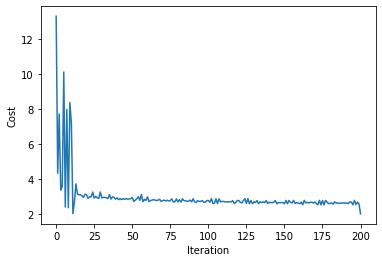

In [13]:
from qiskit.visualization import plot_histogram

#Train Circuit
result=noisyopt.minimizeSPSA(run_circuit_and_calc_cost, params, args=args, bounds=bnds, niter=max_iter, disp=False, paired=False)

print("Success: ", result.success)
print(result.message)
print("Final cost function is ", result.fun)
print("Min possible cost function is ", np.log2(len(target_states)))
print("Number of iterations is ", result.nit)
print("Number of function evaluations is ", result.nfev)
print("Number of parameters was ", len(params))
print("Approximate cost on hardware: $", 0.01*len(cost_history)*shots)

#Plot the evolution of the cost function
plt.figure()
plt.plot(cost_history)
plt.ylabel('Cost')
plt.xlabel('Iteration')


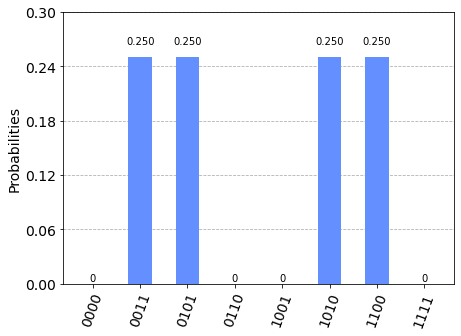

In [14]:
#Visualize the result
result_final=run_iteration(circuit_ansatz(n, result.x, conn,layers,ansatz_type), shots)
plot_histogram(result_final)

Next let's test it on the qpu backend.

Current cost: 7.967195925447372
Current cost: 4.455134314233857
Current cost: 3.6452678305600106
Current cost: 10.084267081745189
Current cost: 7.772911917286937
Current cost: 8.058445129642184
Current cost: 6.213239683656951
Current cost: 7.8990876494883615
Current cost: 7.012338986857827
Current cost: 4.124652290512016
Current cost: 3.6671335408725954
Current cost: 4.605151662511698
Current cost: 4.295776834080034
Current cost: 3.595782986157033
Current cost: 8.040674355126813
Current cost: 4.468746260239452
Current cost: 5.816999058476663
Current cost: 3.2146513244422374
Current cost: 3.319054185177905
Current cost: 4.37199047946214
Current cost: 3.5477951592139556
Current cost: 4.705134314233858
Current cost: 2.9253269761635967
Current cost: 3.7610108246456466
Current cost: 3.576282358156715
Current cost: 6.012338986857827
Current cost: 3.682483677038631
Current cost: 4.031053411816642
Current cost: 2.624172546261479
Current cost: 8.204685754822473
Current cost: 2.4194479950459753


Text(0.5, 0, 'Iteration')

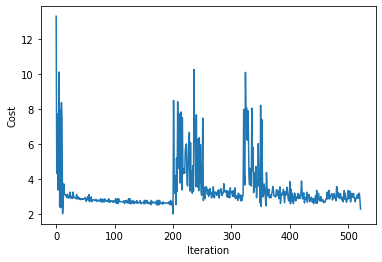

In [17]:
#Train Circuit
backend = provider.get_backend("ionq_qpu")
result=noisyopt.minimizeSPSA(run_circuit_and_calc_cost, params, args=args, bounds=bnds, niter=max_iter, disp=False, paired=False)

print("Success: ", result.success)
print(result.message)
print("Final cost function is ", result.fun)
print("Min possible cost function is ", np.log2(len(target_states)))
print("Number of iterations is ", result.nit)
print("Number of function evaluations is ", result.nfev)
print("Number of parameters was ", len(params))
print("Approximate cost on hardware: $", 0.01*len(cost_history)*shots)

#Plot the evolution of the cost function
plt.figure()
plt.plot(cost_history)
plt.ylabel('Cost')
plt.xlabel('Iteration')

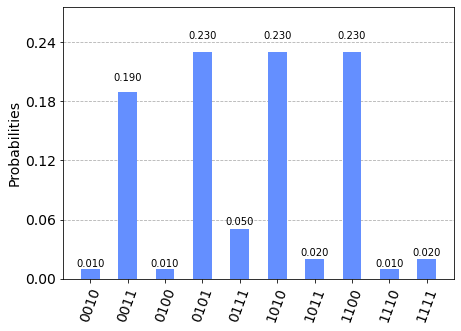

In [19]:
#Visualize the result
result_final=run_iteration(circuit_ansatz(n, result.x, conn,layers,ansatz_type), shots)
plot_histogram(result_final)